In [ ]:
!pip install tfimm

# *Importing Libraries* 

In [ ]:
import os
import cv2
import copy
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, concatenate, Dense, BatchNormalization, Flatten, MaxPooling2D, Dropout

import tfimm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, matthews_corrcoef

# *Preprocessing*

In [ ]:
dataset_path = '/kaggle/input/nasal-bone-fracture-dataset/Dataset+'


paths = []
labels = []
 
for category in ['normal', 'fracture']:
    category_path = os.path.join(dataset_path, category)

    for folder_name in os.listdir(category_path):
        folder_path = os.path.join(category_path, folder_name)

        if os.path.isdir(folder_path):
            for image_name in ['R', 'L']:
                image_path = os.path.join(folder_path, f'{image_name}.jpg')

                if os.path.exists(image_path):
                    paths.append(image_path)
                    labels.append(category)

                    
df = pd.DataFrame({'image_path': paths, 'label': labels})
df.head()

In [ ]:
df.shape

In [6]:
def read_images_from_df(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        img_path = row['image_path']
        if row['label'] == "normal":
            label = 0
        else: label = 1
        img = cv2.imread(img_path)
        if img is not None:
            images.append(img)
            labels.append(label)
    return images, labels

images, labels = read_images_from_df(df)

### Show sample

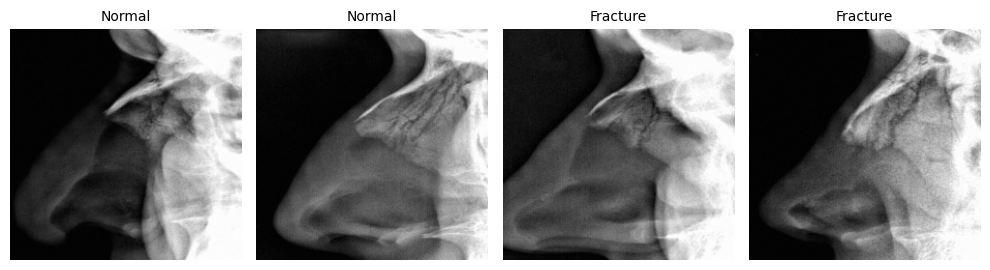

In [7]:
def show_smp(images, labels):
    fig, axes = plt.subplots(1, 4, figsize=(10, 8))
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

    for i in range(4):
        idx = 2 * i + 1474
        ax = axes[i]
        ax.imshow(images[idx])
        if labels[idx] == 0:
            label = 'Normal'
        else:
            label = 'Fracture'
        ax.set_title(label, fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


show_smp(images, labels)

## *Split data on train val test*

In [8]:
X_train, X_val_test, y_train, y_val_test = train_test_split(np.asarray(images), np.asarray(labels), test_size=0.3, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [9]:
print("shape of X_train is: {} ".format(X_train.shape))
print("shape of X_val is: {}".format(X_val.shape))
print("shape of X_test is: {}".format(X_test.shape))
print()
print("shape of y_train is: {} ".format(y_train.shape))
print("shape of y_val is: {}".format(y_val.shape))
print("shape of y_test is: {}".format(y_test.shape))

shape of X_train is: (2077, 224, 224, 3) 
shape of X_val is: (445, 224, 224, 3)
shape of X_test is: (446, 224, 224, 3)

shape of y_train is: (2077,) 
shape of y_val is: (445,)
shape of y_test is: (446,)


## *Data Augmentation*

In [10]:
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow(
    np.array(X_train),
    y_train,
    batch_size=batch_size,
    shuffle=True,
)

validation_generator = validation_datagen.flow(
    np.array(X_val),
    y_val,
    batch_size=batch_size,
    shuffle=False,
)

test_generator = test_datagen.flow(
    np.array(X_test),
    y_test,
    batch_size=batch_size,
    shuffle=False,
)

In [ ]:
classes = np.unique(labels)
classes

In [ ]:
img, lable = train_generator.next()
img.shape

### Show sample:

In [ ]:
def show_sample(img, lable):
    plt.figure(figsize= (12, 12))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img[i])
        plt.title(lable[i])
        plt.axis('off')
    plt.show()
    
show_sample(img, lable)

In [14]:
def draw_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    fig, axis = plt.subplots(1, 2, figsize=(15,6))
    axis[0].set_title('Training & validation accuracy', fontsize = 15, fontweight = 'bold')
    axis[0].plot(acc, label='training accuracy', color='navy')
    axis[0].plot(val_acc, label='validation accuracy', color='deeppink')
    axis[0].legend()
    axis[1].set_title('Training & validation loss', fontsize = 15, fontweight = 'bold')
    axis[1].plot(loss, label='training loss', color='navy')
    axis[1].plot(val_loss, label='validation loss', color='deeppink')
    axis[1].legend()

    print("Maximum Accuracy of Training set: {:.3f}\nMinimum Loss of Trainig set: {:.8f}\n".format(np.max(acc)*100, np.min(loss)))
    print("Maximum Accuracy of Validation set: {:.3f}\nMinimum Loss of Validation set: {:.8f}\n".format(np.max(val_acc)*100, np.min(val_loss)))

In [15]:
def roc_auc_score_(y_test, y_pred):
    auc_ = roc_auc_score(y_test, y_pred)
    print("AUC:", auc_)    
    print()
    
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='navy', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='khaki', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [16]:
def confusion_matrix_(y_test, y_pred, name):
    cm = confusion_matrix(y_test, y_pred)
    cmap = sns.color_palette(["#FFFFFF", "#00004D"]) 

    class_labels = ['normal', 'fracture']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False, linewidths=1.5, 
                linecolor='black', xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted label", fontsize = 12, fontweight = 'bold')
    plt.ylabel("True label", fontsize = 12, fontweight = 'bold')
    plt.title(name, fontsize = 15, fontweight = 'bold')
    plt.show()

In [17]:
def metrics(y_test, y_pred):
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted') 
    f0_5_score = fbeta_score(y_test, y_pred, beta=0.5, average='weighted')
    f1_score = fbeta_score(y_test, y_pred, beta=1, average='weighted')
    f2_score = fbeta_score(y_test, y_pred, beta=2, average='weighted')
    mcc_score = matthews_corrcoef(y_test, y_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = recall 
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    output = (
        f"{'Metric':<15}{'Score':>10}\n"
        f"{'-'*25}\n"
        
        f"{'Sensitivity':<15}{sensitivity:>10.6f}\n" 
        f"{'Specificity':<15}{specificity:>10.6f}\n"
        f"{'F0.5 Score':<15}{f0_5_score:>10.6f}\n"
        f"{'MCC Score':<15}{mcc_score:>10.6f}\n"

        f"{'.'*25}\n"

        f"{'Precision':<15}{precision:>10.6f}\n"
        f"{'Recall':<15}{recall:>10.6f}\n"
        f"{'F1 Score':<15}{f1_score:>10.6f}\n"
        f"{'F2 Score':<15}{f2_score:>10.6f}\n"
    )
    print(output)

In [18]:
def lr_schedule(epoch):
    initial_learning_rate = LR
    decay = 0.92
    lr = initial_learning_rate * decay**(1.25 * epoch)
    if lr > 1e-4:
        return lr
    else:
        return 1e-4
    
lr_scheduler = LearningRateScheduler(lr_schedule)

# *Model Structure*

In [19]:
EPOCHS = 50
IMG_SHAPE = (224, 224, 3)
LR = 5e-4
OPTIMIZER = Adamax(LR)
LOSS = SparseCategoricalCrossentropy()
METRICS = ['accuracy']

In [ ]:
path = "deit_small_patch16_224"

base_model = tfimm.create_model(path, pretrained=True)

base_model.trainable = True
print("Number of layers in the base_model: ", len(base_model.layers))

In [22]:
for layer in base_model.layers[:12]:
    layer.trainable = False

In [23]:
model = Sequential([
    base_model,
    Dropout(0.5),
    BatchNormalization(),
    Dense(64, 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.3),
    BatchNormalization(),
    Dense(len(classes), "sigmoid")
])

model.compile(optimizer = OPTIMIZER, loss = LOSS, metrics = METRICS)

In [24]:
model.build((1,224,224,3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 deit_small_patch16_224 (Vi  (1, 1000)                 22050664  
 T)                                                              
                                                                 
 dropout_98 (Dropout)        (1, 1000)                 0         
                                                                 
 batch_normalization (Batch  (1, 1000)                 4000      
 Normalization)                                                  
                                                                 
 dense (Dense)               (1, 64)                   64064     
                                                                 
 dropout_99 (Dropout)        (1, 64)                   0         
                                                                 
 batch_normalization_1 (Bat  (1, 64)                   2

In [25]:
len(model.trainable_variables)

38

In [26]:
hist = model.fit(train_generator, validation_data = validation_generator, epochs = EPOCHS, callbacks=[lr_scheduler]) 

Epoch 1/50
130/130 [==============================] - 54s 258ms/step - loss: 2.1805 - accuracy: 0.4993 - val_loss: 1.8387 - val_accuracy: 0.5685 - lr: 5.0000e-04
Epoch 2/50
130/130 [==============================] - 31s 241ms/step - loss: 1.9931 - accuracy: 0.5421 - val_loss: 1.7637 - val_accuracy: 0.6067 - lr: 4.5051e-04
Epoch 3/50
130/130 [==============================] - 31s 238ms/step - loss: 1.9269 - accuracy: 0.5585 - val_loss: 1.7516 - val_accuracy: 0.5865 - lr: 4.0592e-04
Epoch 4/50
130/130 [==============================] - 32s 243ms/step - loss: 1.8685 - accuracy: 0.5691 - val_loss: 1.8116 - val_accuracy: 0.5371 - lr: 3.6574e-04
Epoch 5/50
130/130 [==============================] - 31s 241ms/step - loss: 1.8154 - accuracy: 0.5667 - val_loss: 1.6623 - val_accuracy: 0.6157 - lr: 3.2954e-04
Epoch 6/50
130/130 [==============================] - 32s 243ms/step - loss: 1.7366 - accuracy: 0.6095 - val_loss: 1.5894 - val_accuracy: 0.6584 - lr: 2.9692e-04
Epoch 7/50
130/130 [========

Maximum Accuracy of Training set: 79.008
Minimum Loss of Trainig set: 1.03332591

Maximum Accuracy of Validation set: 75.955
Minimum Loss of Validation set: 1.11248839



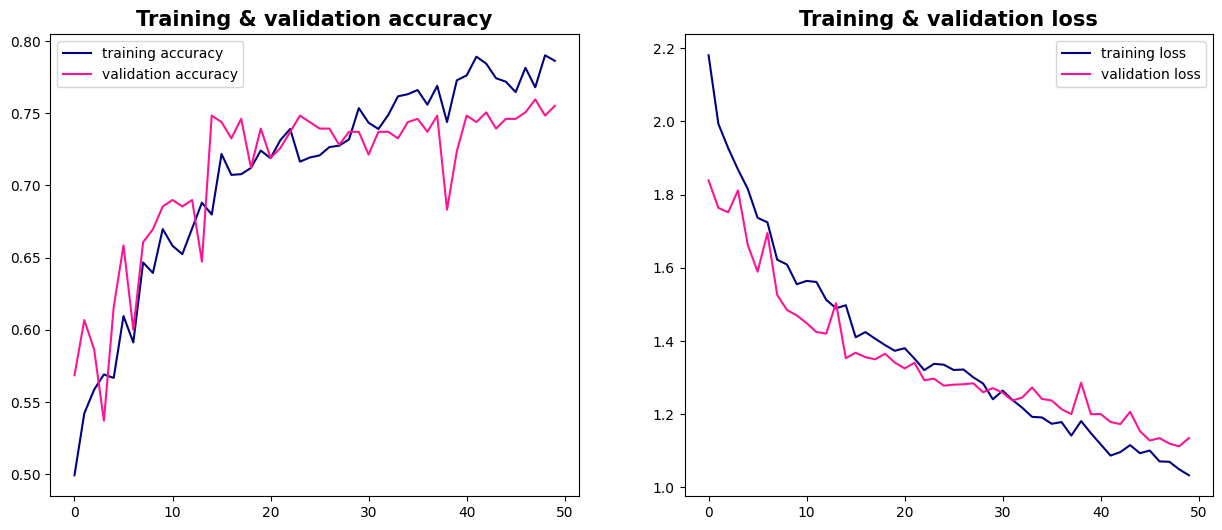

In [28]:
draw_plot(hist)

### *Evaluation*

In [29]:
loss, accuracy = model.evaluate(test_generator)
print('Test accuracy :', accuracy * 100)

28/28 [==============================] - 2s 69ms/step - loss: 1.1049 - accuracy: 0.7870
Test accuracy : 78.6995530128479


In [30]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

28/28 [==============================] - 5s 66ms/step


### *Classification report*

In [31]:
metrics(y_test, y_pred)

Metric              Score
-------------------------
Sensitivity      0.786996
Specificity      0.755459
F0.5 Score       0.787949
MCC Score        0.576228
.........................
Precision        0.789105
Recall           0.786996
F1 Score         0.786904
F2 Score         0.786685



In [32]:
report = classification_report(y_test, y_pred, target_names=['normal', 'fracture'])
print(report)

              precision    recall  f1-score   support

      normal       0.82      0.76      0.78       229
    fracture       0.76      0.82      0.79       217

    accuracy                           0.79       446
   macro avg       0.79      0.79      0.79       446
weighted avg       0.79      0.79      0.79       446



### *Confusion matrix*

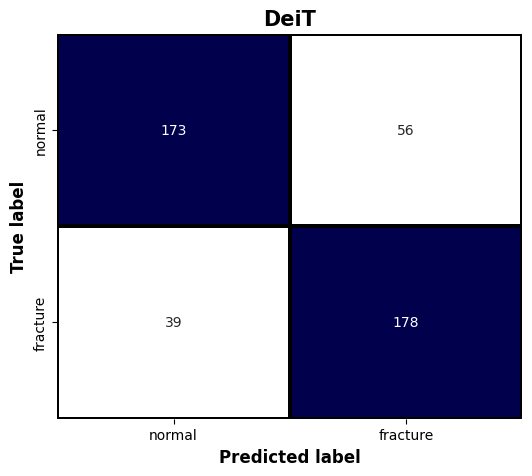

In [34]:
confusion_matrix_(y_test, y_pred, name="DeiT")

### *ROC & AUC*

AUC: 0.7878675064898477



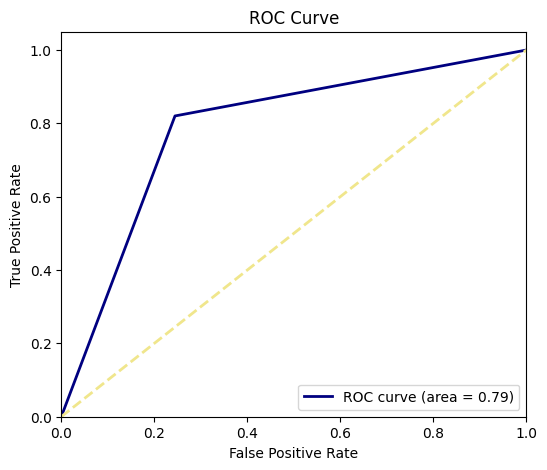

In [35]:
roc_auc_score_(y_test, y_pred)